Number of samples in original training set: 40000
Number of 'normal' samples for autoencoder training: 39800

--- Hyperparameter Tuning for Anomaly Detection Model ---
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Tested: enc_dim=4, int_dim=16, lr=0.001, F1=0.0769
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Tested: enc_dim=4, int_dim=16, lr=0.0001, F1=0.0645
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Tested: enc_dim=4, int_dim=20, lr=0.001, F1=0.0892
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Tested: enc_dim=4, int_dim=20, lr=0.0001, F1=0.0769
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Tested: enc_dim=8, int_dim=16, lr=0.001, F1=0.0769
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Tested: enc_dim=8, int_dim=16, lr=0.0001, F1=0.0769
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Tested: enc_dim=8, int_dim=20, lr=0.001, F1=0.0519
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Tested: enc_dim=8, int_dim=20, lr=0.0001, F1=0.0645

--- Hyperparameter Tuning Results ---
   encoding_dim  intermediate_dim  learning_rate  pre

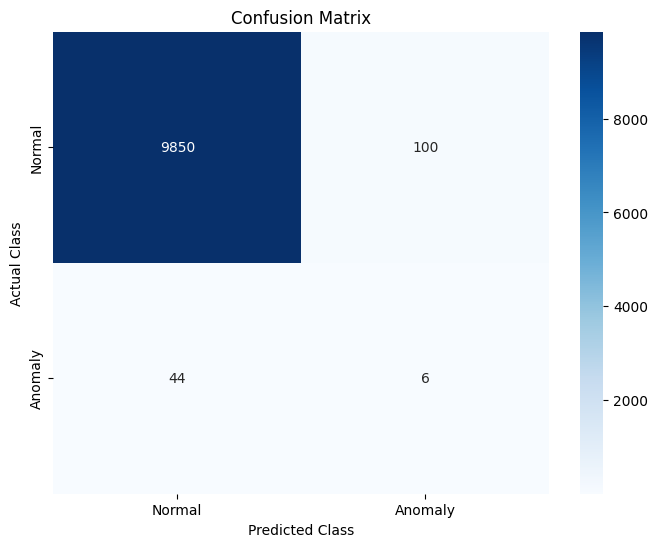

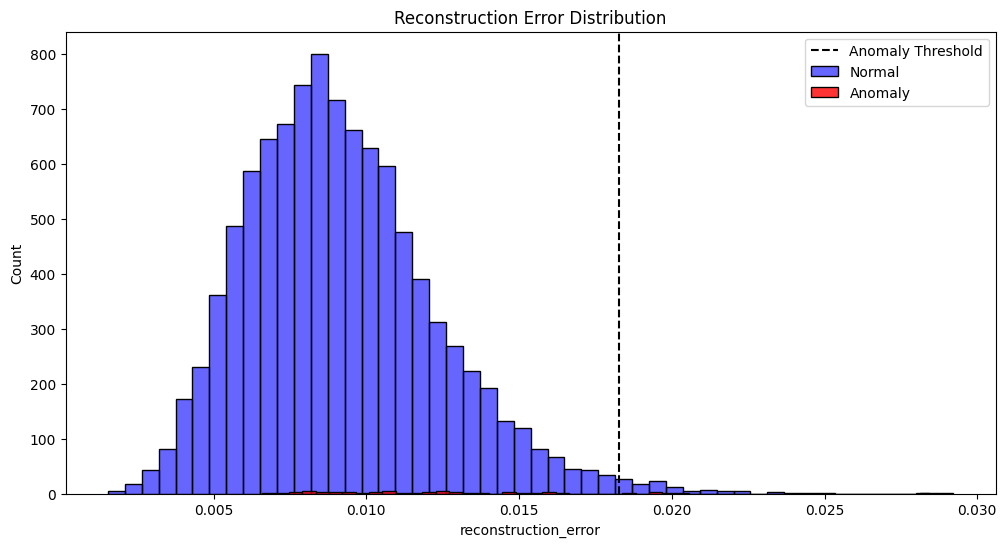

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

# --- When to Use Autoencoders and Data Requirements ---
#
# This script demonstrates a more advanced and realistic approach to anomaly detection
# using autoencoders.
#
# Use Case: Anomaly/Outlier Detection
#   By learning the underlying patterns of "normal" data, autoencoders can identify
#   anomalies, which will have a high reconstruction error. This is ideal for
#   problems like fraud detection, network intrusion detection, or finding defective
#   products from sensor data.
#
# Data Requirements:
#   - Highly Imbalanced Data: This technique shines when anomalies are rare (e.g., <1% of the data).
#   - Numeric & Scaled Data: All input features must be numeric and scaled, typically to a [0, 1] range.
#   - Sufficient "Normal" Data: The model must be trained almost exclusively on normal instances
#     to learn the correct patterns.

# --- 1. Generate a Suitable Dataset ---
# The Wine dataset is not ideal as its classes are balanced. A real-world anomaly
# detection problem, like credit card fraud, is highly imbalanced. We will generate
# a synthetic dataset that mimics this property.
X, y = make_classification(
    n_samples=50000,
    n_features=29,
    n_informative=10,
    n_redundant=5,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=2,
    weights=[0.995, 0.005],  # 99.5% normal, 0.5% anomaly
    flip_y=0,
    random_state=42
)

# --- 2. Prepare and Split the Data ---
# Scale the features to a [0, 1] range.
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# For training the autoencoder, we only use the "normal" data (class 0)
X_train_normal = X_train[y_train == 0]
print(f"Number of samples in original training set: {len(X_train)}")
print(f"Number of 'normal' samples for autoencoder training: {len(X_train_normal)}")


# --- 3. Expanded Hyperparameter Tuning ---
print("\n--- Hyperparameter Tuning for Anomaly Detection Model ---")
param_grid = {
    'encoding_dim': [4, 8],
    'intermediate_dim': [16, 20],
    'learning_rate': [1e-3, 1e-4]
}
results = []

for encoding_dim in param_grid['encoding_dim']:
    for intermediate_dim in param_grid['intermediate_dim']:
        for lr in param_grid['learning_rate']:
            # Define the Autoencoder Model
            input_layer = Input(shape=(X_train.shape[1],))
            encoder = Dense(intermediate_dim, activation="relu")(input_layer)
            encoder = Dense(encoding_dim, activation="relu")(encoder)
            decoder = Dense(intermediate_dim, activation="relu")(encoder)
            decoder = Dense(X_train.shape[1], activation="sigmoid")(decoder)
            autoencoder = Model(inputs=input_layer, outputs=decoder)

            autoencoder.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')

            # Train the model
            autoencoder.fit(X_train_normal, X_train_normal, epochs=20, batch_size=32, shuffle=True, verbose=0)

            # Evaluate on the full test set
            reconstructions = autoencoder.predict(X_test)
            mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)

            # We need a way to measure performance. Let's use a percentile threshold for now.
            threshold = np.quantile(mse[y_test==0], 0.99) # Use 99th percentile of normal test errors
            y_pred = (mse > threshold).astype(int)
            
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

            results.append({
                'encoding_dim': encoding_dim,
                'intermediate_dim': intermediate_dim,
                'learning_rate': lr,
                'precision': precision,
                'recall': recall,
                'f1_score': f1
            })
            print(f"Tested: enc_dim={encoding_dim}, int_dim={intermediate_dim}, lr={lr}, F1={f1:.4f}")

# Display results, sorting by F1-score which is good for imbalanced datasets
results_df = pd.DataFrame(results).sort_values(by='f1_score', ascending=False)
print("\n--- Hyperparameter Tuning Results ---")
print(results_df)

# Choose the best parameters
best_params = results_df.iloc[0]
print(f"\nSelected Best Parameters:\n{best_params}")

# --- 4. Anomaly Detection with Final Tuned Model ---
print("\n--- Applying Final Model for Anomaly Detection ---")
input_layer_final = Input(shape=(X_train.shape[1],))
encoder_final = Dense(int(best_params['intermediate_dim']), activation="relu")(input_layer_final)
encoder_final = Dense(int(best_params['encoding_dim']), activation="relu")(encoder_final)
decoder_final = Dense(int(best_params['intermediate_dim']), activation="relu")(encoder_final)
decoder_final = Dense(X_train.shape[1], activation="sigmoid")(decoder_final)
autoencoder_final = Model(inputs=input_layer_final, outputs=decoder_final)

autoencoder_final.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='mean_squared_error')

# Train the final model for more epochs
print("Training final anomaly detection model...")
autoencoder_final.fit(X_train_normal, X_train_normal, epochs=50, batch_size=32, shuffle=True, verbose=0)
print("Training complete.")

# --- 5. Evaluate the Final Model ---
# Calculate reconstruction error on the full test set
reconstructions = autoencoder_final.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)

# Define a robust anomaly threshold using the 99th percentile of normal errors
# This is generally more effective than the mean+std method for skewed error distributions.
normal_test_errors = mse[y_test == 0]
threshold = np.quantile(normal_test_errors, 0.99)
print(f"\nAnomaly Threshold (99th percentile of normal test error): {threshold:.6f}")

# Classify anomalies
y_pred = (mse > threshold).astype(int)

# --- 6. Visualize Results and Performance ---
# Create a DataFrame for easier analysis
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test, 'predicted_class': y_pred})
print("\n--- Model Performance on Test Set ---")
print(classification_report(error_df['true_class'], error_df['predicted_class'], target_names=['Normal', 'Anomaly']))

# Display Confusion Matrix
cm = confusion_matrix(error_df['true_class'], error_df['predicted_class'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Visualize the reconstruction errors
plt.figure(figsize=(12, 6))
sns.histplot(data=error_df[error_df['true_class'] == 0], x='reconstruction_error', bins=50, color='blue', alpha=0.6, label='Normal')
sns.histplot(data=error_df[error_df['true_class'] == 1], x='reconstruction_error', bins=50, color='red', alpha=0.8, label='Anomaly')
plt.axvline(threshold, color='black', linestyle='--', label='Anomaly Threshold')
plt.title("Reconstruction Error Distribution")
plt.legend()
plt.show()
